# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [6]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [9]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [10]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [19]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>250) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>25": "met_pt>25",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>250) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>30": "met_pt>30",            
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [20]:
events_dict = {}

In [21]:
### new corrections
samples_dir = {
    "2016":    "../eos/postprocessNov12_2016",
    "2016APV": "../eos/postprocessNov12_2016APV",
    "2017":    "../eos/postprocessNov12_2017",
    "2018":    "../eos/postprocessNov12_2018",
}

# years = ["2017", "2016", "2016APV", "2018"]
years = ["2016"]
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict = {**events_dict, **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1145 events
INFO:root:Applying lep_fj_dr08 selection on 1145 events
INFO:root:Applying fj_pt300 selection on 1145 events
INFO:root:Applying dphi<1.57 selection on 88 events
INFO:root:Applying tagger>0.5 selection on 21 events
INFO:root:Applying MET>30 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016H
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2016F
INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets


Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125157 events
INFO:root:Applying lep_fj_dr08 selection on 125157 events
INFO:root:Applying fj_pt300 selection on 125157 events
INFO:root:Applying dphi<1.57 selection on 119189 events
INFO:root:Applying tagger>0.5 selection on 76297 events
INFO:root:Applying MET>30 selection on 2137 events
INFO:root:Will fill the DYJets dataframe with the remaining 1857 events
INFO:root:tot event weight 6.879404259851901 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 452 events
INFO:root:Applying lep_fj_dr08 selection on 452 events
INFO:root:Applying fj_pt300 selection on 452 events
INFO:root:Applying dphi<1.57 selection on 221 events
INFO:root:Applying tagger>0.5 selection on 150 events
INFO:root:Applying MET>30 selection on 106 events
INFO:root:Will fill the VBF d

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 63781 events
INFO:root:Applying lep_fj_dr08 selection on 63781 events
INFO:root:Applying fj_pt300 selection on 63781 events
INFO:root:Applying dphi<1.57 selection on 59702 events
INFO:root:Applying tagger>0.5 selection on 47349 events
INFO:root:Applying MET>30 selection on 8636 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7980 events
INFO:root:tot event weight 341.4248259103672 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 75025 events
INFO:root:Applying lep_fj_dr08 selection on 75025 events
INFO:root:Applying fj_pt300 selection on 75025 events
INFO:root:Applying dphi<1.57 selection on 46531 events
INFO:root:Applying tagger>0.5 selection on 32904 events
INFO:root:Applying MET>30 selection on 2620 events
INFO:root:Will fill the TTbar dataframe with the remaining 2294 events
INFO:root:tot even

INFO:root:Applying MET>30 selection on 0 events
INFO:root:Will fill the WZQQ dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding QCD_Pt_120to170 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 67 events
INFO:root:Applying lep_fj_dr08 selection on 67 events
INFO:root:Applying fj_pt300 selection on 67 events
INFO:root:Applying dphi<1.57 selection on 8 events
INFO:root:Applying tagger>0.5 selection on 1 events
INFO:root:Applying MET>30 selection on 0 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 210 events
INFO:root:Applying lep_fj_dr08 selection on 210 events
INFO:root:Applying fj_pt300 selection on 210 events
INFO:root:Applying dphi<1.57

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10095 events
INFO:root:Applying lep_fj_dr08 selection on 10095 events
INFO:root:Applying fj_pt300 selection on 10095 events
INFO:root:Applying dphi<1.57 selection on 7138 events
INFO:root:Applying tagger>0.5 selection on 5026 events
INFO:root:Applying MET>30 selection on 262 events
INFO:root:Will fill the SingleTop dataframe with the remaining 229 events
INFO:root:tot event weight 0.815978808537318 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20179 events
INFO:root:Applying lep_fj_dr08 selection on 20179 events
INFO:root:Applying fj_pt300 selection on 20179 events
INFO:root:Applying dphi<1.57 selection on 8021 events
INFO:root:Applying tagger>0.5 selection on 3584 events
INFO:root:Applying MET>30 selection on 702 events
INFO:root:Will fill the DYJets dataframe

INFO:root:Applying dphi<1.57 selection on 4545 events


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying tagger>0.5 selection on 2075 events
INFO:root:Applying MET>30 selection on 217 events
INFO:root:Will fill the QCD dataframe with the remaining 105 events
INFO:root:tot event weight 240.16767928949517 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1129 events
INFO:root:Applying lep_fj_dr08 selection on 1129 events
INFO:root:Applying fj_pt300 selection on 1129 events
INFO:root:Applying dphi<1.57 selection on 1058 events
INFO:root:Applying tagger>0.5 selection on 492 events
INFO:root:Applying MET>30 selection on 79 events
INFO:root:Will fill the WZQQ dataframe with the remaining 54 events
INFO:root:tot event weight 5.005863630636361 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 624 events
INFO:root:Applying le

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49996 events
INFO:root:Applying lep_fj_dr08 selection on 49996 events
INFO:root:Applying fj_pt300 selection on 49996 events
INFO:root:Applying dphi<1.57 selection on 43597 events
INFO:root:Applying tagger>0.5 selection on 33091 events
INFO:root:Applying MET>30 selection on 7215 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6394 events
INFO:root:tot event weight 615.9560469225572 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 761 events
INFO:root:Applying lep_fj_dr08 selection on 761 events
INFO:root:Applying fj_pt300 selection on 761 events
INFO:root:Applying dphi<1.57 selection on 641 events
INFO:root:Applying tagger>0.5 selection on 296 events
INFO:root:Applying MET>30 selection on 58 events
INFO:root:Will fill the WZQQ dataframe with the remaining 23 events
INFO:root:tot event weight 4.

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10323 events
INFO:root:Applying lep_fj_dr08 selection on 10323 events
INFO:root:Applying fj_pt300 selection on 10323 events
INFO:root:Applying dphi<1.57 selection on 6696 events
INFO:root:Applying tagger>0.5 selection on 4294 events
INFO:root:Applying MET>30 selection on 1889 events
INFO:root:Will fill the ttH dataframe with the remaining 1624 events
INFO:root:tot event weight 2.44839606777456 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt300 selection on 767 events
INFO:root:Applying dphi<1.57 selection on 732 events
INFO:root:Applying tagger>0.5 selection on 361 events
INFO:root:Applying MET>30 selection on 59 events
INFO:root:Will fill the WZQQ dataframe with the remainin

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 259992 events
INFO:root:Applying lep_fj_dr08 selection on 259992 events
INFO:root:Applying fj_pt300 selection on 259992 events
INFO:root:Applying dphi<1.57 selection on 115050 events
INFO:root:Applying tagger>0.5 selection on 59778 events
INFO:root:Applying MET>30 selection on 6867 events
INFO:root:Will fill the DYJets dataframe with the remaining 3595 events
INFO:root:tot event weight 79.64734379332475 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1273 events
INFO:root:Applying lep_fj_dr08 selection on 1273 events
INFO:root:Applying fj_pt300 selection on 1273 events
INFO:root:Applying dphi<1.57 selection on 102 events
INFO:root:Applying tagger>0.5 selection on 16 events
INFO:root:Applying MET>25 selection on 1 events
INFO:root:Will fill the WJetsLNu datafra

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 78929 events
INFO:root:Applying lep_fj_dr08 selection on 78929 events
INFO:root:Applying fj_pt300 selection on 78929 events
INFO:root:Applying dphi<1.57 selection on 37806 events
INFO:root:Applying tagger>0.5 selection on 23492 events
INFO:root:Applying MET>25 selection on 4690 events
INFO:root:Will fill the Data dataframe with the remaining 4100 events
INFO:root:tot event weight 4100.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 3808 events
INFO:root:Applying lep_fj_dr08 selection on 3808 events
INFO:root:Applying fj_pt300 selection on 3808 events
INFO:root:Applying dphi<1.57 selection on 1820 events
INFO:root:Applying tagger>0.5 selection on 1135 events
INFO:root:Applying MET>25 selection on 216 events
INFO:root:Will fill the Data dataframe with the remaining 190 events
INFO:root:tot event weight 190.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and 

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 92490 events
INFO:root:Applying lep_fj_dr08 selection on 92490 events
INFO:root:Applying fj_pt300 selection on 92490 events
INFO:root:Applying dphi<1.57 selection on 86639 events
INFO:root:Applying tagger>0.5 selection on 69191 events
INFO:root:Applying MET>25 selection on 16546 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15713 events
INFO:root:tot event weight 692.716617736121 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 87877 events
INFO:root:Applying lep_fj_dr08 selection on 87877 events
INFO:root:Applying fj_pt300 selection on 87877 events
INFO:root:Applying dphi<1.57 selection on 53712 events
INFO:root:Applying tagger>0.5 selection on 37770 events
INFO:root:Applying MET>25 selection on 3560 events
INFO:root:Will fill the TTbar dataframe

INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 14737 events
INFO:root:Applying lep_fj_dr08 selection on 14737 events
INFO:root:Applying fj_pt300 selection on 14737 events
INFO:root:Applying dphi<1.57 selection on 10077 events
INFO:root:Applying tagger>0.5 selection on 7136 events
INFO:root:Applying MET>25 selection on 460 events
INFO:root:Will fill the SingleTop dataframe with the remaining 417 events
INFO:root:tot event weight 1.3632593875742172 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 23982 events
INFO:root:Applying lep_fj_dr08 selection on 23982 events
INFO:root:Applying fj_pt300 selection on 23982 events
INFO:root:Applying dphi<1.57 selection on 9581 events
INFO:root:Applying tagger>0.5 selection on 4571 events
INFO:root:Applying MET>25 selection on 1125 events
INFO:root:Will fill the DYJets dataframe with the remaining 709 events
INFO:root:tot e

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4707 events
INFO:root:Applying lep_fj_dr08 selection on 4707 events
INFO:root:Applying fj_pt300 selection on 4707 events
INFO:root:Applying dphi<1.57 selection on 4607 events
INFO:root:Applying tagger>0.5 selection on 3602 events
INFO:root:Applying MET>25 selection on 460 events
INFO:root:Will fill the QCD dataframe with the remaining 428 events
INFO:root:tot event weight 16.075202858926886 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2585 events
INFO:root:Applying lep_fj_dr08 selection on 2585 events
INFO:root:Applying fj_pt300 selection on 2585 events
INFO:root:Applying dphi<1.57 selection on 2245 events
INFO:root:Applying tagger>0.5 selection on 1698 events
INFO:root:Applying MET>25 selection on 246 events
INFO:root:Will fill the QCD dataframe with the remaining 202

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 73761 events
INFO:root:Applying lep_fj_dr08 selection on 73761 events
INFO:root:Applying fj_pt300 selection on 73761 events
INFO:root:Applying dphi<1.57 selection on 64187 events
INFO:root:Applying tagger>0.5 selection on 48911 events
INFO:root:Applying MET>25 selection on 13402 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 12433 events
INFO:root:tot event weight 1222.7340058832056 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 400 events
INFO:root:Applying lep_fj_dr08 selection on 400 events
INFO:root:Applying fj_pt300 selection on 400 events
INFO:root:Applying dphi<1.57 selection on 284 events
INFO:root:Applying tagger>0.5 selection on 205 events
INFO:root:Applying MET>25 selection on 74 events
INFO:root:Will fill the WZQQ dataframe with t

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying dphi<1.57 selection on 47401 events
INFO:root:Applying tagger>0.5 selection on 38123 events
INFO:root:Applying MET>25 selection on 3533 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3465 events
INFO:root:tot event weight 1.9190043811216633 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10484 events
INFO:root:Applying lep_fj_dr08 selection on 10484 events
INFO:root:Applying fj_pt300 selection on 10484 events
INFO:root:Applying dphi<1.57 selection on 6770 events
INFO:root:Applying tagger>0.5 selection on 4456 events
INFO:root:Applying MET>25 selection on 2385 events
INFO:root:Will fill the ttH dataframe with the remaining 2129 events
INFO:root:tot event weight 3.011337816611917 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Appl

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 187926 events
INFO:root:Applying lep_fj_dr08 selection on 187926 events
INFO:root:Applying fj_pt300 selection on 187926 events
INFO:root:Applying dphi<1.57 selection on 72658 events
INFO:root:Applying tagger>0.5 selection on 41276 events
INFO:root:Applying MET>25 selection on 8022 events
INFO:root:Will fill the DYJets dataframe with the remaining 5535 events
INFO:root:tot event weight 120.5832513642995 



In [47]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_composition_table(ev, tagger, presel, years, channels):

    num_sig = {
        "ggF": 0, 
        "ttH": 0, 
        "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0

    samples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end


    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')

    print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

# Stacked hists

In [48]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [49]:
vars_to_plot = [
#     "fj_minus_lep_m",
    "fj_pt",
#     "lep_pt",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met",    
    "rec_higgs_m",
#     "fj_msoftdrop",    
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [50]:
# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "Pre-selection": f"{tagger}>0.5",
    #### put any selection you want, e.g.:
    "top cut": "( (n_bjets_T>=1) & (fj_pt>300) ) | (lep_pt>300)", 
}

channels = ["ele", "mu"]
# years = ["2018", "2017", "2016", "2016APV"]
years = ["2016"]

# fill histograms
hists = {}

ev = events_dict
for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]

                df = df.query(sel)

                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"],
                )     
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

DYJets, has 2 bins with negative yield.. will set them to 0


Will plot fj_pt histogram
Will plot rec_higgs_m histogram

top cut (2016):
------------------------
Signal: 6.05
- VBF: 2%
- VH: 10%
- ggF: 22%
- ttH: 65%
------------------------
Background: 2313.72
- DYJets: 1%
- Others: 5%
- QCD: 6%
- WJetsLNu: 13%
- TTbar: 75%


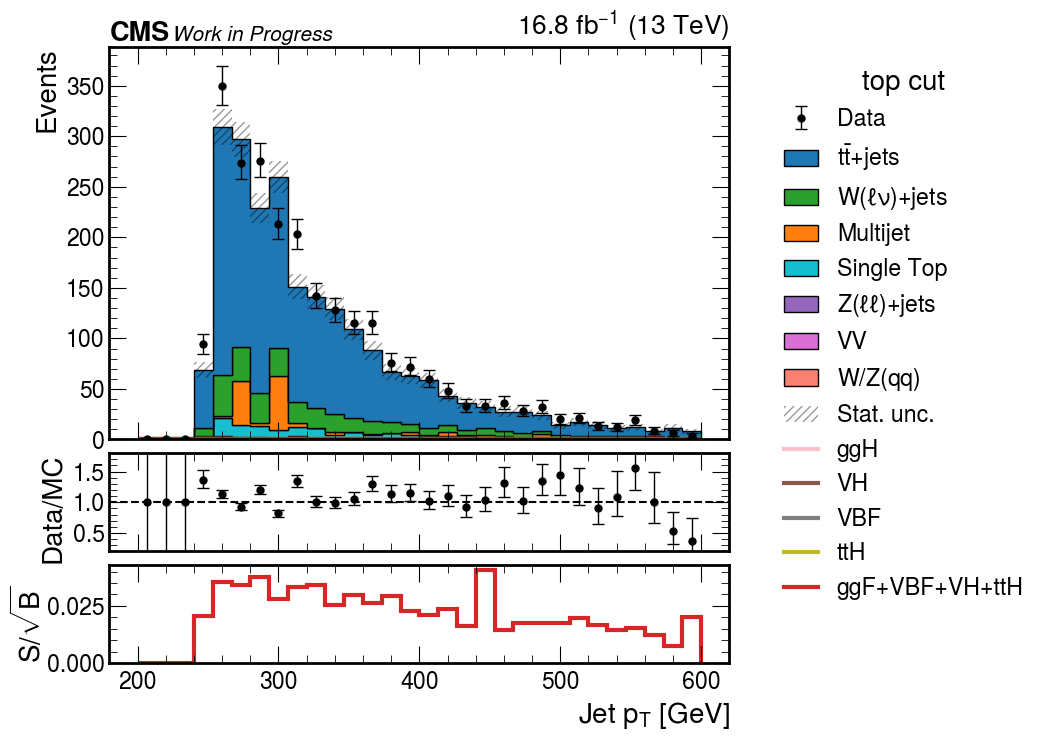

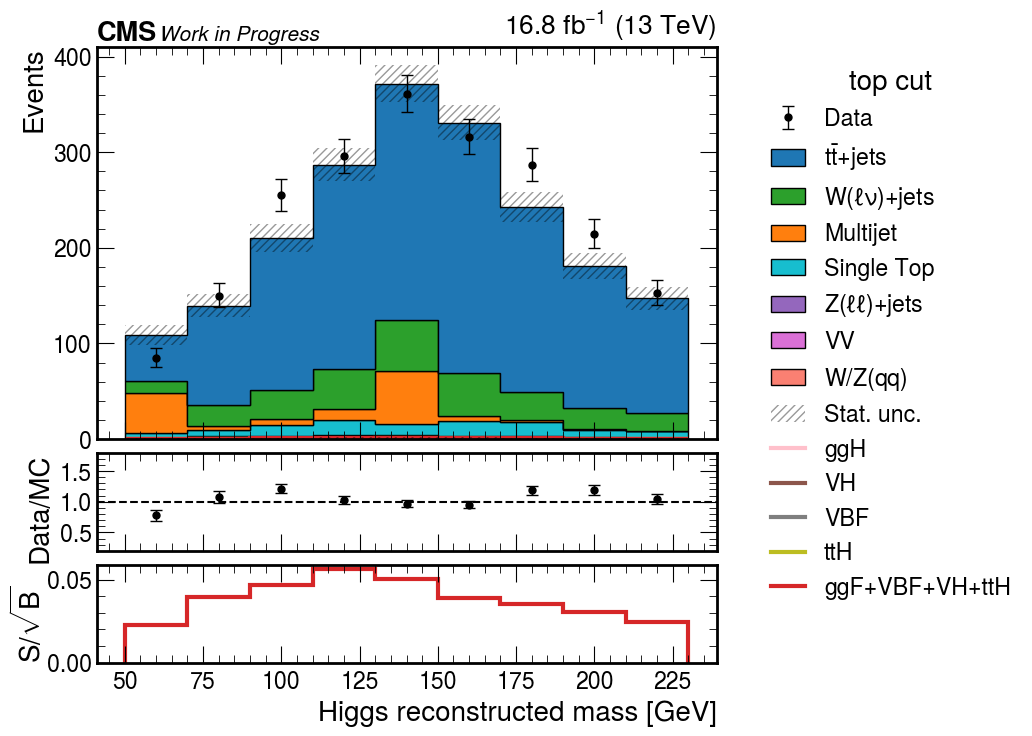

In [51]:
plt.rcParams.update({"font.size": 20})
add_data = True
    
utils.plot_hists(years, channels, hists, vars_to_plot,             
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=1,
            outpath=f"/Users/fmokhtar/Desktop/AN/",           
            text_=region,
          )
print()
get_composition_table(ev, tagger, presel, years, channels)